Loading Audio File: /Users/raghavsuri/Downloads/bleh.wav
Audio File Exported to: temp_audio.wav
Selected Input File: /Users/raghavsuri/Downloads/bleh.wav
Loading Audio File: /Users/raghavsuri/Downloads/bleh.wav
Audio File Exported to: temp_audio.wav
Temporary Audio File Created: temp_audio.wav
Processing File: temp_audio.wav
Audio Loaded with SR: 16000
Noise reduction completed.
Bandpass filter applied.
Audio processed and saved to: /Users/raghavsuri/Downloads/wfef.wav


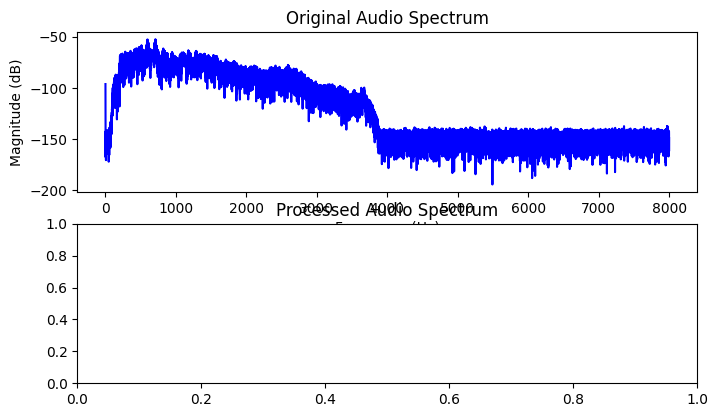

In [9]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import os
from pydub import AudioSegment
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from noisereduce import reduce_noise
from scipy.signal import butter, lfilter
import soundfile as sf

# Helper Functions
def load_audio(file_path):
    """Convert input audio to mono WAV format for processing."""
    try:
        print(f"Loading Audio File: {file_path}")  # Debug
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Input file not found: {file_path}")
        
        audio = AudioSegment.from_file(file_path)
        if audio.channels > 1:
            audio = audio.set_channels(1)
        temp_path = "temp_audio.wav"
        audio.export(temp_path, format="wav")
        print(f"Audio File Exported to: {temp_path}")  # Debug
        return temp_path
    except Exception as e:
        raise ValueError(f"Error loading audio: {e}")

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply bandpass filter to the audio data."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def process_audio(input_file, output_file, lowcut, highcut):
    """Process the audio file: denoise and filter."""
    try:
        print(f"Processing File: {input_file}")  # Debug
        if not os.path.exists(input_file):
            raise FileNotFoundError(f"Input file not found during processing: {input_file}")
        
        y, sr = librosa.load(input_file, sr=16000)
        print(f"Audio Loaded with SR: {sr}")  # Debug
        noise_profile = y[:sr * 2]  # Use first 2 seconds as noise profile
        denoised_audio = reduce_noise(y=y, sr=sr, y_noise=noise_profile)
        print("Noise reduction completed.")  # Debug
        filtered_audio = bandpass_filter(denoised_audio, lowcut=lowcut, highcut=highcut, fs=sr)
        print("Bandpass filter applied.")  # Debug
        sf.write(output_file, filtered_audio, sr)
        print(f"Audio processed and saved to: {output_file}")  # Debug
        return y, denoised_audio, filtered_audio, sr
    finally:
        # Cleanup temporary files
        if os.path.exists("temp_audio.wav"):
            os.remove("temp_audio.wav")

def plot_spectrum(ax, data, sr, title):
    """Plot the magnitude spectrum of audio data."""
    ax.clear()
    ax.magnitude_spectrum(data, Fs=sr, scale='dB', color='blue')
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')

# Tkinter UI
def browse_file():
    """Browse and load an audio file."""
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav *.mp3 *.flac")])
    if file_path:
        input_file_var.set(file_path)  # Store full path
        dropdown['values'] = (*dropdown['values'], file_path)  # Use full path
        dropdown.set(file_path)  # Display full path
        try:
            temp_audio = load_audio(file_path)
            original_audio, sr = librosa.load(temp_audio, sr=16000)
            os.remove(temp_audio)
            plot_spectrum(ax1, original_audio, sr, "Original Audio Spectrum")
            canvas.draw()
        except Exception as e:
            print(e)
            messagebox.showerror("Error", f"Error loading audio: {e}")

def process_and_visualize():
    """Process the selected audio and visualize results."""
    input_file = input_file_var.get()
    if not input_file or not os.path.exists(input_file):
        messagebox.showerror("Error", f"Input file not found: {input_file}")
        return
    lowcut = int(lowcut_var.get())
    highcut = int(highcut_var.get())
    output_file = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV Files", "*.wav")])
    if not output_file:
        return

    try:
        print(f"Selected Input File: {input_file}")  # Debug
        temp_audio = load_audio(input_file)
        print(f"Temporary Audio File Created: {temp_audio}")  # Debug
        original_audio, denoised_audio, filtered_audio, sr = process_audio(temp_audio, output_file, lowcut, highcut)
        os.remove(temp_audio)
        print("Temporary audio file removed.")  # Debug
        plot_spectrum(ax2, filtered_audio, sr, "Processed Audio Spectrum")
        canvas.draw()
        messagebox.showinfo("Success", f"Processed audio saved to {output_file}")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Initialize Tkinter window
root = tk.Tk()
root.title("Noise Removal and Enhancement Tool")
root.geometry("800x600")

# Input File Selection
input_file_var = tk.StringVar()
input_frame = tk.Frame(root)
input_frame.pack(pady=10)
input_label = tk.Label(input_frame, text="Select Audio File:")
input_label.pack(side=tk.LEFT, padx=5)
browse_button = tk.Button(input_frame, text="Browse", command=browse_file)
browse_button.pack(side=tk.LEFT, padx=5)
dropdown = ttk.Combobox(input_frame, textvariable=input_file_var, state="readonly", values=[])
dropdown.pack(side=tk.LEFT, padx=5)

# Bandpass Filter Controls
filter_frame = tk.Frame(root)
filter_frame.pack(pady=10)
lowcut_label = tk.Label(filter_frame, text="Low Cut (Hz):")
lowcut_label.pack(side=tk.LEFT, padx=5)
lowcut_var = tk.StringVar(value="200")
lowcut_entry = tk.Entry(filter_frame, textvariable=lowcut_var, width=10)
lowcut_entry.pack(side=tk.LEFT, padx=5)
highcut_label = tk.Label(filter_frame, text="High Cut (Hz):")
highcut_label.pack(side=tk.LEFT, padx=5)
highcut_var = tk.StringVar(value="3000")
highcut_entry = tk.Entry(filter_frame, textvariable=highcut_var, width=10)
highcut_entry.pack(side=tk.LEFT, padx=5)

# Process and Visualize Button
process_button = tk.Button(root, text="Process and Visualize", command=process_and_visualize)
process_button.pack(pady=10)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax2.set_title("Processed Audio Spectrum")  # Placeholder title
canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack()

# Run the Tkinter application
root.mainloop()


Loading Audio File: /Users/raghavsuri/Downloads/cas.wav
Audio File Exported to: temp_audio.wav
Selected Input File: /Users/raghavsuri/Downloads/cas.wav
Loading Audio File: /Users/raghavsuri/Downloads/cas.wav
Audio File Exported to: temp_audio.wav
Temporary Audio File Created: temp_audio.wav
Processing File: temp_audio.wav
Audio Loaded with SR: 16000
Noise reduction completed.
Bandpass filter applied.
Audio processed and saved to: /Users/raghavsuri/Downloads/ascacsasc.wav
Temporary audio file removed.


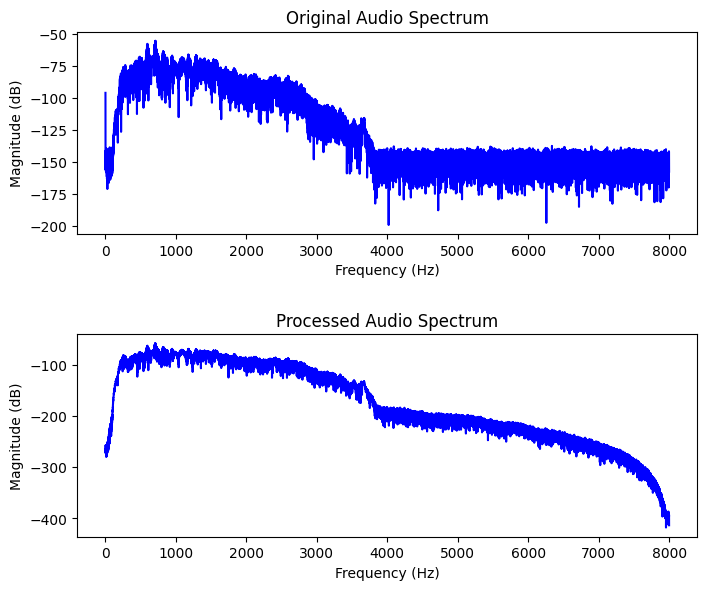

In [12]:
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
import os
from pydub import AudioSegment
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from noisereduce import reduce_noise
from scipy.signal import butter, lfilter
import soundfile as sf

# Helper Functions
def load_audio(file_path):
    """Convert input audio to mono WAV format for processing."""
    try:
        print(f"Loading Audio File: {file_path}")  # Debug
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Input file not found: {file_path}")
        
        audio = AudioSegment.from_file(file_path)
        if audio.channels > 1:
            audio = audio.set_channels(1)
        temp_path = "temp_audio.wav"
        audio.export(temp_path, format="wav")
        print(f"Audio File Exported to: {temp_path}")  # Debug
        return temp_path
    except Exception as e:
        raise ValueError(f"Error loading audio: {e}")

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply bandpass filter to the audio data."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

def process_audio(input_file, output_file, lowcut, highcut):
    """Process the audio file: denoise and filter."""
    try:
        print(f"Processing File: {input_file}")  # Debug
        if not os.path.exists(input_file):
            raise FileNotFoundError(f"Input file not found during processing: {input_file}")
        
        y, sr = librosa.load(input_file, sr=16000)
        print(f"Audio Loaded with SR: {sr}")  # Debug
        noise_profile = y[:sr * 2]  # Use first 2 seconds as noise profile
        denoised_audio = reduce_noise(y=y, sr=sr, y_noise=noise_profile)
        print("Noise reduction completed.")  # Debug
        filtered_audio = bandpass_filter(denoised_audio, lowcut=lowcut, highcut=highcut, fs=sr)
        print("Bandpass filter applied.")  # Debug
        sf.write(output_file, filtered_audio, sr)
        print(f"Audio processed and saved to: {output_file}")  # Debug
        return y, denoised_audio, filtered_audio, sr
    except Exception as e:
        raise e

def plot_spectrum(ax, data, sr, title):
    """Plot the magnitude spectrum of audio data."""
    ax.clear()
    ax.magnitude_spectrum(data, Fs=sr, scale='dB', color='blue')
    ax.set_title(title)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')

# Tkinter UI
def browse_file():
    """Browse and load an audio file."""
    file_path = filedialog.askopenfilename(filetypes=[("Audio Files", "*.wav *.mp3 *.flac")])
    if file_path:
        input_file_var.set(file_path)  # Store full path
        dropdown['values'] = (*dropdown['values'], file_path)  # Use full path
        dropdown.set(file_path)  # Display full path
        try:
            temp_audio = load_audio(file_path)
            original_audio, sr = librosa.load(temp_audio, sr=16000)
            plot_spectrum(ax1, original_audio, sr, "Original Audio Spectrum")
            canvas.draw()
        except Exception as e:
            print(e)
            messagebox.showerror("Error", f"Error loading audio: {e}")


def process_and_visualize():
    """Process the selected audio and visualize results."""
    input_file = input_file_var.get()
    if not input_file or not os.path.exists(input_file):
        messagebox.showerror("Error", f"Input file not found: {input_file}")
        return
    lowcut = int(lowcut_var.get())
    highcut = int(highcut_var.get())
    output_file = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV Files", "*.wav")])
    if not output_file:
        return

    try:
        print(f"Selected Input File: {input_file}")  # Debug
        temp_audio = load_audio(input_file)
        print(f"Temporary Audio File Created: {temp_audio}")  # Debug
        original_audio, denoised_audio, filtered_audio, sr = process_audio(temp_audio, output_file, lowcut, highcut)
        plot_spectrum(ax2, filtered_audio, sr, "Processed Audio Spectrum")
        canvas.draw()
        os.remove(temp_audio)
        print("Temporary audio file removed.")  # Debug
        messagebox.showinfo("Success", f"Processed audio saved to {output_file}")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {e}")

# Initialize Tkinter window
root = tk.Tk()
root.title("Noise Removal and Enhancement Tool")
root.geometry("1000x800")

# Input File Selection
input_file_var = tk.StringVar()
input_frame = tk.Frame(root)
input_frame.pack(pady=10)
input_label = tk.Label(input_frame, text="Select Audio File:")
input_label.pack(side=tk.LEFT, padx=5)
browse_button = tk.Button(input_frame, text="Browse", command=browse_file)
browse_button.pack(side=tk.LEFT, padx=5)
dropdown = ttk.Combobox(input_frame, textvariable=input_file_var, state="readonly", values=[])
dropdown.pack(side=tk.LEFT, padx=5)

# Bandpass Filter Controls
filter_frame = tk.Frame(root)
filter_frame.pack(pady=10)
lowcut_label = tk.Label(filter_frame, text="Low Cut (Hz):")
lowcut_label.pack(side=tk.LEFT, padx=5)
lowcut_var = tk.StringVar(value="200")
lowcut_entry = tk.Entry(filter_frame, textvariable=lowcut_var, width=10)
lowcut_entry.pack(side=tk.LEFT, padx=5)
highcut_label = tk.Label(filter_frame, text="High Cut (Hz):")
highcut_label.pack(side=tk.LEFT, padx=5)
highcut_var = tk.StringVar(value="3000")
highcut_entry = tk.Entry(filter_frame, textvariable=highcut_var, width=10)
highcut_entry.pack(side=tk.LEFT, padx=5)

# Process and Visualize Button
process_button = tk.Button(root, text="Process and Visualize", command=process_and_visualize)
process_button.pack(pady=10)



# Plotting
fig, axes = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 0.2, 1]})
ax1, spacer, ax2 = axes
ax1.set_title("Original Audio Spectrum")
ax2.set_title("Processed Audio Spectrum")
spacer.axis('off')  # Remove the axes for the spacer subplot

canvas = FigureCanvasTkAgg(fig, master=root)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack()





# Run the Tkinter application
root.mainloop()

